In [1]:
import pandas as pd

In [2]:
df_multiple_notes = pd.read_csv("../data/cleaned_notes.csv")
df_multiple_notes.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,diagnosis_category,gender,anchor_age,anchor_year,anchor_year_group,...,note_id,note_type,note_seq,charttime,storetime,text,note_length,anchor_date,days_since_anchor,cleaned_note_text
0,10070024,26769931,1,F323,10,Major Depression,F,23,2142,2014 - 2016,...,10070024-DS-13,DS,13.0,2145-01-29,2145-01-29 09:59:00,\nName: ___ Unit No: ___...,20409,2142-01-01,1124,\nName: ___ Unit No: ___...
1,10070024,26398294,1,F3189,10,Bipolar Disorder,F,23,2142,2014 - 2016,...,10070024-DS-14,DS,14.0,2145-02-09,2145-02-09 11:46:00,\nName: ___ Unit No: ___...,17868,2142-01-01,1135,"Chief Complaint:\n""I made a mistake. ""\n \nMaj..."
2,10080985,24679803,1,F332,10,Major Depression,F,22,2179,2014 - 2016,...,10080985-DS-16,DS,16.0,2179-05-13,2179-05-13 15:28:00,\nName: ___ Unit No: ___...,14035,2179-01-01,132,\nName: ___ Unit No: ___...
3,10080985,26523165,1,F329,10,Major Depression,F,22,2179,2014 - 2016,...,10080985-DS-15,DS,15.0,2179-05-11,2180-08-14 18:55:00,\nName: ___ Unit No: ___...,7168,2179-01-01,130,Chief Complaint:\ngenetic predisposition to br...
4,10266157,29245849,1,F332,10,Major Depression,F,76,2194,2011 - 2013,...,10266157-DS-22,DS,22.0,2198-10-22,2198-10-26 07:11:00,\nName: ___ Unit No: ___\...,11648,2194-01-01,1755,\nName: ___ Unit No: ___\...


In [3]:
#!pip install --quiet nltk Levenshtein

In [20]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [21]:
def split_into_sentences(text):
    doc = nlp(text)
    return [
        " ".join(sent.text.lower().split())  # lowercase + strip extra internal spaces
        for sent in doc.sents
        if sent.text.strip()
    ]

In [6]:
import re

def normalize_numbers(sentence, number_token="<num>"):
    # Replace any number (integer, float, years, decimals) with a special token
    return re.sub(r"\b\d+(\.\d+)?\b", number_token, sentence)

def split_normalized_sentences(text, number_token="<num>"):
    doc = nlp(text)
    return [
        normalize_numbers(" ".join(sent.text.lower().split()), number_token)
        for sent in doc.sents
        if sent.text.strip()
    ]


In [7]:
from nltk.util import ngrams

# Match sentences exactly
def exact_sentence_match(curr_sentences, prev_sentences):
    prev_set = set(prev_sentences)
    return [sent for sent in curr_sentences if sent in prev_set]


In [23]:
# Match n-grams (6-10 words)
def exact_ngram_match(curr_sentences, prev_sentences, n_min=6, n_max=10):
    prev_ngrams = set()
    for sent in prev_sentences:
        tokens = sent.split()
        tokens = [token.text.lower() for token in nlp(sent)]
        for n in range(n_min, n_max+1):
            prev_ngrams.update(ngrams(tokens, n))

    repeated = []
    for sent in curr_sentences:
        tokens = [token.text for token in nlp(sent)]
        tokens = [token.text.lower() for token in nlp(sent)]
        for n in range(n_min, n_max + 1):
            for gram in ngrams(tokens, n):
                if gram in prev_ngrams:
                    print(f"Match found in sentence: \"{sent}\"")
                    print(f"Shared {n}-gram: {' '.join(gram)}\n")
                    repeated.append(sent)
                    break
            else:
                print(f"No shared {n}-gram.")
                continue
            print("exit loop")
            break

    return repeated

In [24]:
# Case 1: Shares only a 6-gram
prev_1 = ["The patient is stable and resting at bed."]
curr_1 = ["Patient is stable and resting at home with family."]

# Case 2: Shares both 6-gram to 10-gram
prev_2 = ["Patient reports no chest pain and no shortness of breath yesterday."]
curr_2 = ["The Patient reports no chest pain and no shortness of breath today."]

# Case 3: No shared n-gram
prev_3 = ["Blood pressure within normal range, continue monitoring."]
curr_3 = ["Follow-up scheduled for next Monday regarding lab results."]

# Test each pair
print("=== Case 1 ===")
exact_ngram_match(curr_1, prev_1)

print("\n=== Case 2 ===")
exact_ngram_match(curr_2, prev_2)

print("\n=== Case 3 ===")
exact_ngram_match(curr_3, prev_3)


=== Case 1 ===
Match found in sentence: "Patient is stable and resting at home with family."
Shared 6-gram: patient is stable and resting at

exit loop

=== Case 2 ===
Match found in sentence: "The Patient reports no chest pain and no shortness of breath today."
Shared 6-gram: patient reports no chest pain and

exit loop

=== Case 3 ===
No shared 6-gram.
No shared 7-gram.
No shared 8-gram.
No shared 9-gram.
No shared 10-gram.


[]

In [19]:
# Match n-grams (6-10 words)
def exact_ngram_match(curr_sentences, prev_sentences, n_min=6, n_max=10):
    prev_ngrams = set()
    for sent in prev_sentences:
        tokens = [token.text for token in nlp(sent)]
        for n in range(n_min, n_max+1):
            prev_ngrams.update(ngrams(tokens, n))

    repeated = []
    for sent in curr_sentences:
        tokens = [token.text for token in nlp(sent)]
        for n in range(n_min, n_max + 1):
            for gram in ngrams(tokens, n):
                if gram in prev_ngrams:
                    repeated.append(sent)
                    break
            else:
                continue
            break

    return repeated

In [20]:
from collections import defaultdict
from tqdm import tqdm

methods = {
    # "Exact Sentence Match": {
    #     "func": exact_sentence_match,
    #     "has_score": False
    # },
    "Exact Ngram Match": {
        "func": exact_ngram_match,
        "has_score": False
    },
    # "Levenshtein Match": {
    #     "func": levenshtein_match_with_scores,
    #     "has_score": True
    # },
    # "Sentence Transformer Match": {
    #     "func": mpnet_similarity_filter_with_scores,
    #     "has_score": True
    # },
    # "LCS Match": {
    #     "func": lcs_sequence_match_with_scores,
    #     "has_score": True
    # }
}

# Track cumulative statistics
results = {
    method: {
        "total_sentences": 0,
        "repeated_sentences": 0,
        "total_words": 0,
        "repeated_words": 0,
        "note_count": 0,
        "word_diffs": [],     # list of word differences per note
        "percent_removed": [] # list of percent removed per note
    } for method in methods.keys()
}

# Ensure correct datetime and sort
df_multiple_notes['storetime'] = pd.to_datetime(df_multiple_notes['storetime'])
df_multiple_notes = df_multiple_notes.sort_values(by=["subject_id", "storetime"])

# Add empty columns before the loop:
for method_name in methods:
    df_multiple_notes[f"text_kept_{method_name.lower().replace(' ', '_')}"] = None
    if methods[method_name]["has_score"]:
        df_multiple_notes[f"similarity_scores_{method_name.lower().replace(' ', '_')}"] = None

for subject_id, group in tqdm(df_multiple_notes.groupby("subject_id"), desc="Processing Patients"):
    group = group.sort_values("storetime")
    prev_note = None

    for idx, row in group.iterrows():
        curr_text = row['text']
        curr_sentences = split_into_sentences(curr_text)
        curr_word_count = sum(len(sent.split()) for sent in curr_sentences)

        if prev_note is not None:
            prev_sentences = split_into_sentences(prev_note)

            for method_name, method in methods.items():
                method_func = method["func"]
                has_score = method["has_score"]

                if has_score:
                    repeated_sents, similarity_scores = method_func(curr_sentences, prev_sentences)
                else:
                    repeated_sents = method_func(curr_sentences, prev_sentences)
                    similarity_scores = [0] * len(curr_sentences)  # dummy placeholder

                repeated_words = sum(len(sent.split()) for sent in repeated_sents)
                kept_sentences = [s for s in curr_sentences if s not in repeated_sents]

                # Safely access and assign values using row.name (which is index in df_multiple_notes)
                df_multiple_notes.at[row.name, f"text_kept_{method_name.lower().replace(' ', '_')}"] = kept_sentences
                if has_score:
                    df_multiple_notes.at[row.name, f"similarity_scores_{method_name.lower().replace(' ', '_')}"] = similarity_scores

                # Update stats
                stats = results[method_name]
                stats["total_sentences"] += len(curr_sentences)
                stats["repeated_sentences"] += len(repeated_sents)
                stats["total_words"] += curr_word_count
                stats["repeated_words"] += repeated_words
                stats["note_count"] += 1
                stats["word_diffs"].append(repeated_words)
                stats["percent_removed"].append(repeated_words / curr_word_count if curr_word_count else 0)

        # Move to next note
        prev_note = curr_text



Processing Patients: 100%|██████████| 227/227 [20:36<00:00,  5.45s/it]


In [22]:
import numpy as np
for method_name, stat in results.items():
    sent_total = stat["total_sentences"]
    sent_repeated = stat["repeated_sentences"]
    word_total = stat["total_words"]
    word_repeated = stat["repeated_words"]
    note_count = stat["note_count"]

    avg_word_removed = np.mean(stat["word_diffs"]) if stat["word_diffs"] else 0
    avg_percent_removed = np.mean(stat["percent_removed"]) * 100 if stat["percent_removed"] else 0

    print(f"\n {method_name}")
    print(f"  - Total sentences: {sent_total}")
    print(f"  - Repeated sentences: {sent_repeated} ({(sent_repeated / sent_total * 100):.2f}%)")
    print(f"  - Total words: {word_total}")
    print(f"  - Repeated words: {word_repeated} ({(word_repeated / word_total * 100):.2f}%)")
    print(f"  - Notes processed: {note_count}")
    print(f"  - Avg. words removed per note: {avg_word_removed:.2f}")
    print(f"  - Avg. % of words removed per note: {avg_percent_removed:.2f}%")



 Exact Ngram Match
  - Total sentences: 59816
  - Repeated sentences: 15802 (26.42%)
  - Total words: 905795
  - Repeated words: 310108 (34.24%)
  - Notes processed: 339
  - Avg. words removed per note: 914.77
  - Avg. % of words removed per note: 34.50%


In [11]:
import Levenshtein

def levenshtein_match_with_scores(curr_sentences, prev_sentences, threshold=0.85):
    repeated = []
    ratios = []
    for curr in curr_sentences:
        max_ratio = max(
            [Levenshtein.ratio(curr, prev) for prev in prev_sentences] or [0]
        )
        ratios.append(max_ratio)
        if max_ratio >= threshold:
            repeated.append(curr)
    return repeated, ratios



In [12]:
#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('all-mpnet-base-v2')

In [13]:
from sentence_transformers import util

def mpnet_similarity_filter_with_scores(curr_sentences, prev_sentences, threshold=0.85):
    if not curr_sentences or not prev_sentences:
        return [], [0.0] * len(curr_sentences)  # Empty note

    embeddings_curr = model.encode(curr_sentences, convert_to_tensor=True)
    embeddings_prev = model.encode(prev_sentences, convert_to_tensor=True)

    repeated = []
    similarity_scores = []

    for i in range(len(curr_sentences)):
        scores = util.cos_sim(embeddings_curr[i], embeddings_prev)
        max_score = scores.max().item()
        similarity_scores.append(max_score)

        if max_score >= threshold:
            repeated.append(curr_sentences[i])

    return repeated, similarity_scores

In [14]:
# import difflib

# def lcs_sequence_match_with_scores(curr_sentences, prev_sentences, threshold=0.85):
#     repeated = []
#     scores = []

#     for curr_sent in curr_sentences:
#         max_similarity = max(
#             [difflib.SequenceMatcher(None, curr_sent, prev_sent).ratio()
#              for prev_sent in prev_sentences],
#             default=0
#         )
#         scores.append(max_similarity)
#         if max_similarity >= threshold:
#             repeated.append(curr_sent)

#     return repeated, scores

def lcs_length_word_level(tokens1, tokens2):
    """Compute the length of the longest common subsequence between two word-token lists."""
    m, n = len(tokens1), len(tokens2)
    dp = [0] * (n + 1)
    for i in range(m):
        prev_dp = dp[:]
        for j in range(n):
            if tokens1[i] == tokens2[j]:
                dp[j + 1] = prev_dp[j] + 1
            else:
                dp[j + 1] = max(dp[j], prev_dp[j + 1])
    return dp[-1]

def lcs_sequence_match_with_scores(curr_sentences, prev_sentences, threshold=0.85):
    repeated = []
    scores = []

    # Pre-tokenize previous sentences
    prev_tokens_list = [sent.split() for sent in prev_sentences]

    for curr_sent in curr_sentences:
        curr_tokens = curr_sent.split()
        if not curr_tokens:
            scores.append(0.0)
            continue

        max_score = 0.0
        for prev_tokens in prev_tokens_list:
            if not prev_tokens:
                continue
            lcs_len = lcs_length_word_level(curr_tokens, prev_tokens)
            score = lcs_len / len(curr_tokens)  # normalize by current sentence length
            if score > max_score:
                max_score = score

        scores.append(max_score)
        if max_score >= threshold:
            repeated.append(curr_sent)

    return repeated, scores


In [15]:
from collections import defaultdict
from tqdm import tqdm

methods = {
    "Exact Sentence Match": {
        "func": exact_sentence_match,
        "has_score": False
    },
    "Exact Ngram Match": {
        "func": exact_ngram_match,
        "has_score": False
    },
    "Levenshtein Match": {
        "func": levenshtein_match_with_scores,
        "has_score": True
    },
    "Sentence Transformer Match": {
        "func": mpnet_similarity_filter_with_scores,
        "has_score": True
    },
    "LCS Match": {
        "func": lcs_sequence_match_with_scores,
        "has_score": True
    }
}

# Track cumulative statistics
results = {
    method: {
        "total_sentences": 0,
        "repeated_sentences": 0,
        "total_words": 0,
        "repeated_words": 0,
        "note_count": 0,
        "word_diffs": [],     # list of word differences per note
        "percent_removed": [] # list of percent removed per note
    } for method in methods.keys()
}

# Ensure correct datetime and sort
df_multiple_notes['storetime'] = pd.to_datetime(df_multiple_notes['storetime'])
df_multiple_notes = df_multiple_notes.sort_values(by=["subject_id", "storetime"])

# Add empty columns before the loop:
for method_name in methods:
    df_multiple_notes[f"text_kept_{method_name.lower().replace(' ', '_')}"] = None
    if methods[method_name]["has_score"]:
        df_multiple_notes[f"similarity_scores_{method_name.lower().replace(' ', '_')}"] = None

for subject_id, group in tqdm(df_multiple_notes.groupby("subject_id"), desc="Processing Patients"):
    group = group.sort_values("storetime")
    prev_note = None

    for idx, row in group.iterrows():
        curr_text = row['text']
        curr_sentences = split_into_sentences(curr_text)
        curr_word_count = sum(len(sent.split()) for sent in curr_sentences)

        if prev_note is not None:
            prev_sentences = split_into_sentences(prev_note)

            for method_name, method in methods.items():
                method_func = method["func"]
                has_score = method["has_score"]

                if has_score:
                    repeated_sents, similarity_scores = method_func(curr_sentences, prev_sentences)
                else:
                    repeated_sents = method_func(curr_sentences, prev_sentences)
                    similarity_scores = [0] * len(curr_sentences)  # dummy placeholder

                repeated_words = sum(len(sent.split()) for sent in repeated_sents)
                kept_sentences = [s for s in curr_sentences if s not in repeated_sents]

                # Safely access and assign values using row.name (which is index in df_multiple_notes)
                df_multiple_notes.at[row.name, f"text_kept_{method_name.lower().replace(' ', '_')}"] = kept_sentences
                if has_score:
                    df_multiple_notes.at[row.name, f"similarity_scores_{method_name.lower().replace(' ', '_')}"] = similarity_scores

                # Update stats
                stats = results[method_name]
                stats["total_sentences"] += len(curr_sentences)
                stats["repeated_sentences"] += len(repeated_sents)
                stats["total_words"] += curr_word_count
                stats["repeated_words"] += repeated_words
                stats["note_count"] += 1
                stats["word_diffs"].append(repeated_words)
                stats["percent_removed"].append(repeated_words / curr_word_count if curr_word_count else 0)

        # Move to next note
        prev_note = curr_text



Processing Patients:   0%|          | 0/227 [00:00<?, ?it/s]

Processing Patients: 100%|██████████| 227/227 [30:13<00:00,  7.99s/it]


In [16]:
import numpy as np
for method_name, stat in results.items():
    sent_total = stat["total_sentences"]
    sent_repeated = stat["repeated_sentences"]
    word_total = stat["total_words"]
    word_repeated = stat["repeated_words"]
    note_count = stat["note_count"]

    avg_word_removed = np.mean(stat["word_diffs"]) if stat["word_diffs"] else 0
    avg_percent_removed = np.mean(stat["percent_removed"]) * 100 if stat["percent_removed"] else 0

    print(f"\n {method_name}")
    print(f"  - Total sentences: {sent_total}")
    print(f"  - Repeated sentences: {sent_repeated} ({(sent_repeated / sent_total * 100):.2f}%)")
    print(f"  - Total words: {word_total}")
    print(f"  - Repeated words: {word_repeated} ({(word_repeated / word_total * 100):.2f}%)")
    print(f"  - Notes processed: {note_count}")
    print(f"  - Avg. words removed per note: {avg_word_removed:.2f}")
    print(f"  - Avg. % of words removed per note: {avg_percent_removed:.2f}%")



 Exact Sentence Match
  - Total sentences: 59816
  - Repeated sentences: 7875 (13.17%)
  - Total words: 905795
  - Repeated words: 82325 (9.09%)
  - Notes processed: 339
  - Avg. words removed per note: 242.85
  - Avg. % of words removed per note: 9.08%

 Exact Ngram Match
  - Total sentences: 59816
  - Repeated sentences: 5954 (9.95%)
  - Total words: 905795
  - Repeated words: 148328 (16.38%)
  - Notes processed: 339
  - Avg. words removed per note: 437.55
  - Avg. % of words removed per note: 16.14%

 Levenshtein Match
  - Total sentences: 59816
  - Repeated sentences: 10807 (18.07%)
  - Total words: 905795
  - Repeated words: 121901 (13.46%)
  - Notes processed: 339
  - Avg. words removed per note: 359.59
  - Avg. % of words removed per note: 13.63%

 Sentence Transformer Match
  - Total sentences: 59816
  - Repeated sentences: 12649 (21.15%)
  - Total words: 905795
  - Repeated words: 149325 (16.49%)
  - Notes processed: 339
  - Avg. words removed per note: 440.49
  - Avg. % of w

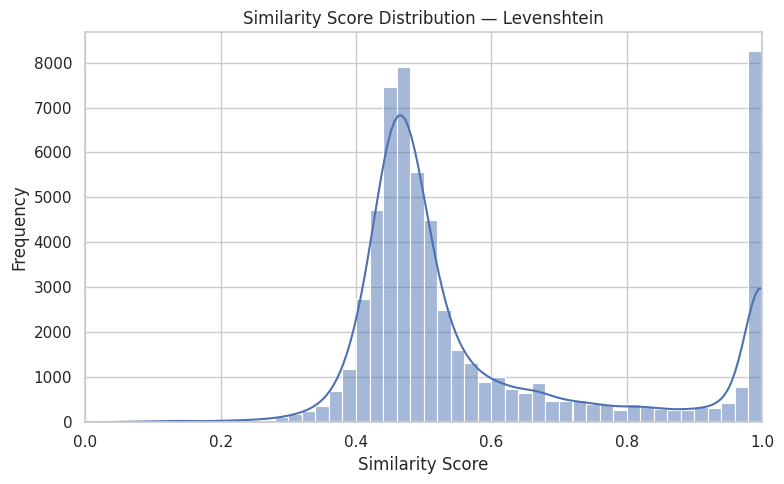

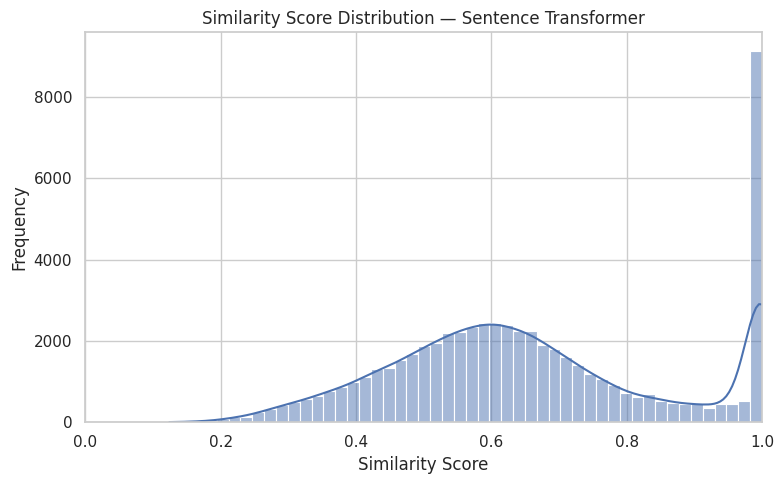

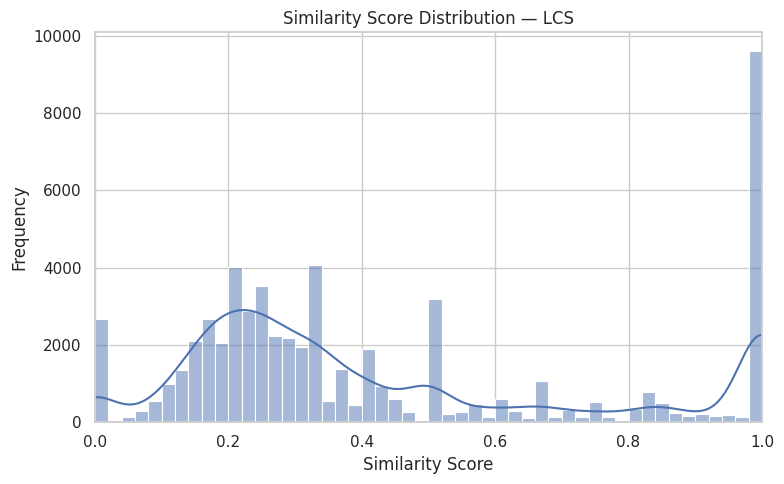

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

score_columns = {
    "Levenshtein": "similarity_scores_levenshtein_match",
    "Sentence Transformer": "similarity_scores_sentence_transformer_match",
    "LCS": "similarity_scores_lcs_match"
}


for method_name, col_name in score_columns.items():
    scores = []

    # Flatten the list of scores
    for score_list in df_multiple_notes[col_name].dropna():
        if isinstance(score_list, list):
            scores.extend(score_list)

    if not scores:
        continue

    # Plot for this method
    plt.figure(figsize=(8, 5))
    sns.histplot(scores, bins=50, kde=True)
    plt.title(f"Similarity Score Distribution — {method_name}")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


In [28]:
df_multiple_notes.iloc[1, :]

subject_id                                                                               10070024
hadm_id                                                                                  26398294
seq_num                                                                                         1
icd_code                                                                                    F3189
icd_version                                                                                    10
diagnosis_category                                                               Bipolar Disorder
gender                                                                                          F
anchor_age                                                                                     23
anchor_year                                                                                  2142
anchor_year_group                                                                     2014 - 2016
dod                 

In [29]:
df_multiple_notes.to_csv("../data/multiple_note.csv", index = False)

In [2]:
import pandas as pd
df_multiple_notes = pd.read_csv("../data/multiple_note.csv")
df_multiple_notes.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,diagnosis_category,gender,anchor_age,anchor_year,anchor_year_group,...,days_since_anchor,cleaned_note_text,text_kept_exact_sentence_match,text_kept_exact_ngram_match,text_kept_levenshtein_match,similarity_scores_levenshtein_match,text_kept_sentence_transformer_match,similarity_scores_sentence_transformer_match,text_kept_lcs_match,similarity_scores_lcs_match
0,10070024,26769931,1,F323,10,Major Depression,F,23,2142,2014 - 2016,...,1124,\nName: ___ Unit No: ___...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10070024,26398294,1,F3189,10,Bipolar Disorder,F,23,2142,2014 - 2016,...,1135,"Chief Complaint:\n""I made a mistake. ""\n \nMaj...","['chief complaint: ""i made a mistake.', '"" maj...","['no: ___', 'chief complaint: ""i made a mistak...","['chief complaint: ""i made a mistake.', '"" maj...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.54154727...","['chief complaint: ""i made a mistake.', '"" maj...","[1.0, 1.0000001192092896, 1.0000001192092896, ...","['chief complaint: ""i made a mistake.', '"" maj...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.37735849..."
2,10080985,24679803,1,F332,10,Major Depression,F,22,2179,2014 - 2016,...,132,\nName: ___ Unit No: ___...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10080985,26523165,1,F329,10,Major Depression,F,22,2179,2014 - 2016,...,130,Chief Complaint:\ngenetic predisposition to br...,['sex: f service: emergency allergies: amoxici...,"['no: ___', 'patient herself denies any signif...",['chief complaint: genetic predisposition to b...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.8837209302325582, ...",['chief complaint: genetic predisposition to b...,"[1.0000001192092896, 1.0, 1.0, 1.0, 1.0, 0.932...",['chief complaint: genetic predisposition to b...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.30555555555..."
4,10266157,29245849,1,F332,10,Major Depression,F,76,2194,2011 - 2013,...,1755,\nName: ___ Unit No: ___\...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
import ast

# Apply to the entire column
df_multiple_notes["similarity_scores_lcs_match"] = df_multiple_notes["similarity_scores_lcs_match"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_multiple_notes["text_kept_lcs_match"] = df_multiple_notes["text_kept_lcs_match"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


In [18]:
from collections import Counter
# Check types of non-null entries
column_name = "similarity_scores_lcs_match"

non_na_entries = df_multiple_notes[column_name].dropna()

# Show first few types
for i, entry in enumerate(non_na_entries):
    print(f"Entry {i}: type = {type(entry)}")
    if isinstance(entry, list):
        print(f"  - Inner type sample: {[type(x) for x in entry[:3]]}")
    if i >= 10:
        break

entry_types = [type(entry).__name__ for entry in non_na_entries]
type_counts = Counter(entry_types)
print("Top-level types in the column:")
print(type_counts)


Entry 0: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 1: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 2: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 3: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 4: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 5: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 6: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 7: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 8: type = <class 'list'>
  - Inner type sample: [<class 'float'>, <class 'float'>, <class 'float'>]
Entry 9: type = <class 'list'>
  - Inner type 

In [ ]:
lcs_lengths = []

for idx, row in df_multiple_notes.iterrows():
    text = row.get("text")
    lcs_scores = row.get("similarity_scores_lcs_match")

    if not isinstance(text, str) or not isinstance(lcs_scores, list):
        continue

    sentences = split_into_sentences(text)

    if len(sentences) != len(lcs_scores):
        print(f"Skipping row {idx}: mismatch between sentence count and score count.")
        continue

    for sent, score in zip(sentences, lcs_scores):
        try:
            word_count = len(sent.split())
            lcs_length = float(score) * word_count  # convert score to float in case it's still str
            lcs_lengths.append(lcs_length)
        except Exception as e:
            print(f"Error in sentence at row {idx}: {e}")
            continue


In [34]:
num_lcs_6_or_more = sum(lcs_len >= 6 for lcs_len in lcs_lengths)
print(f"Number of sentences with LCS length ≥ 6: {num_lcs_6_or_more}")

Number of sentences with LCS length ≥ 6: 17227


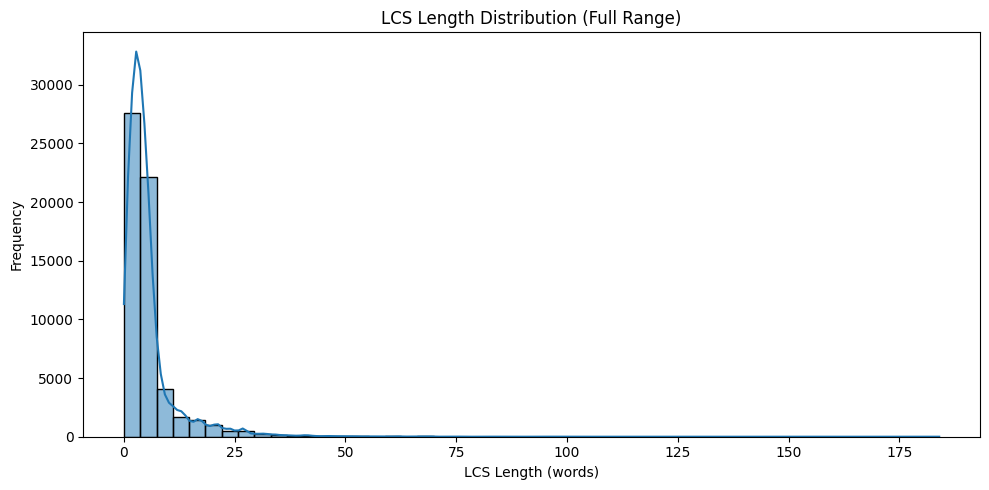

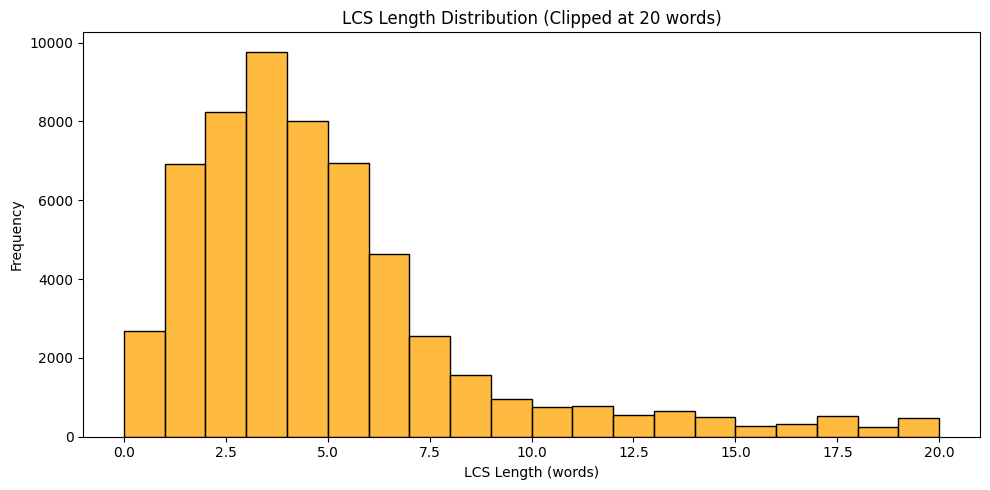

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to numpy array for easier clipping
lcs_lengths_array = np.array(lcs_lengths)

# Plot 1: Full distribution
plt.figure(figsize=(10, 5))
sns.histplot(lcs_lengths_array, bins=50, kde=True)
plt.title("LCS Length Distribution (Full Range)")
plt.xlabel("LCS Length (words)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot 2: Clipped distribution (e.g., LCS ≤ 50 words)
clip_threshold = 20
lcs_lengths_clipped = lcs_lengths_array[lcs_lengths_array <= clip_threshold]

plt.figure(figsize=(10, 5))
sns.histplot(lcs_lengths_clipped, bins=20, color="orange")
plt.title(f"LCS Length Distribution (Clipped at {clip_threshold} words)")
plt.xlabel("LCS Length (words)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
